# Load libraries

In [1]:
import sys
import os
print('Using Python version ' + sys.version)
print('This script is run using the operating system `' +  sys.platform + '`')

Using Python version 3.12.10 | packaged by conda-forge | (main, Apr 10 2025, 22:19:24) [Clang 18.1.8 ]
This script is run using the operating system `darwin`


In [2]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
from matplotlib import font_manager as fm, rcParams

from sklearn.decomposition import PCA
from scipy.ndimage.filters import gaussian_filter
import numpy as np
import csv

/var/folders/jn/x2x9w_8n77b_g5cnyyfbzc9w0000gp/T/ipykernel_10005/1656695892.py:7: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


# Define Color maps

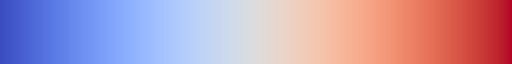

In [3]:
scw = []

with open('../../data/processed_data/common/smooth-cool-warm-table-float-1024.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for i, rows in enumerate(reader):
        if i > 0:
            r = [float(i) for i in rows]
            scw.append(tuple(r[1:]))
            scw.append(r[0])
            
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = list(seq) + [(None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return colors.LinearSegmentedColormap('CustomMap', cdict)

c = colors.ColorConverter().to_rgb
rvb = make_colormap(scw)
rvb

# Color palette

In [4]:
blue = [0.229999504, 0.298998934, 0.754000139]
red = [0.706000136, 0.015991824, 0.150000072]

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.copper_r(np.linspace(0., 1, 128))
colors2 = plt.cm.gray(np.linspace(0, 1, 128))

# combine them and build a new colormap
colors_ = np.vstack((colors1, colors2))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colors_)

cmap1 = colors.ListedColormap(['black'])
colors1 = cmap1(np.linspace(0, 1, 30))
colors2 = plt.cm.copper(np.linspace(0, 1, 128))

colors_ = np.vstack((colors1, colors2))
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap2', colors_)

cmap = rvb
cmap1 = colors.ListedColormap(['white', 'None', 'white'])
cmap2 = colors.ListedColormap(['white'])

# Extended Data Figure 4a

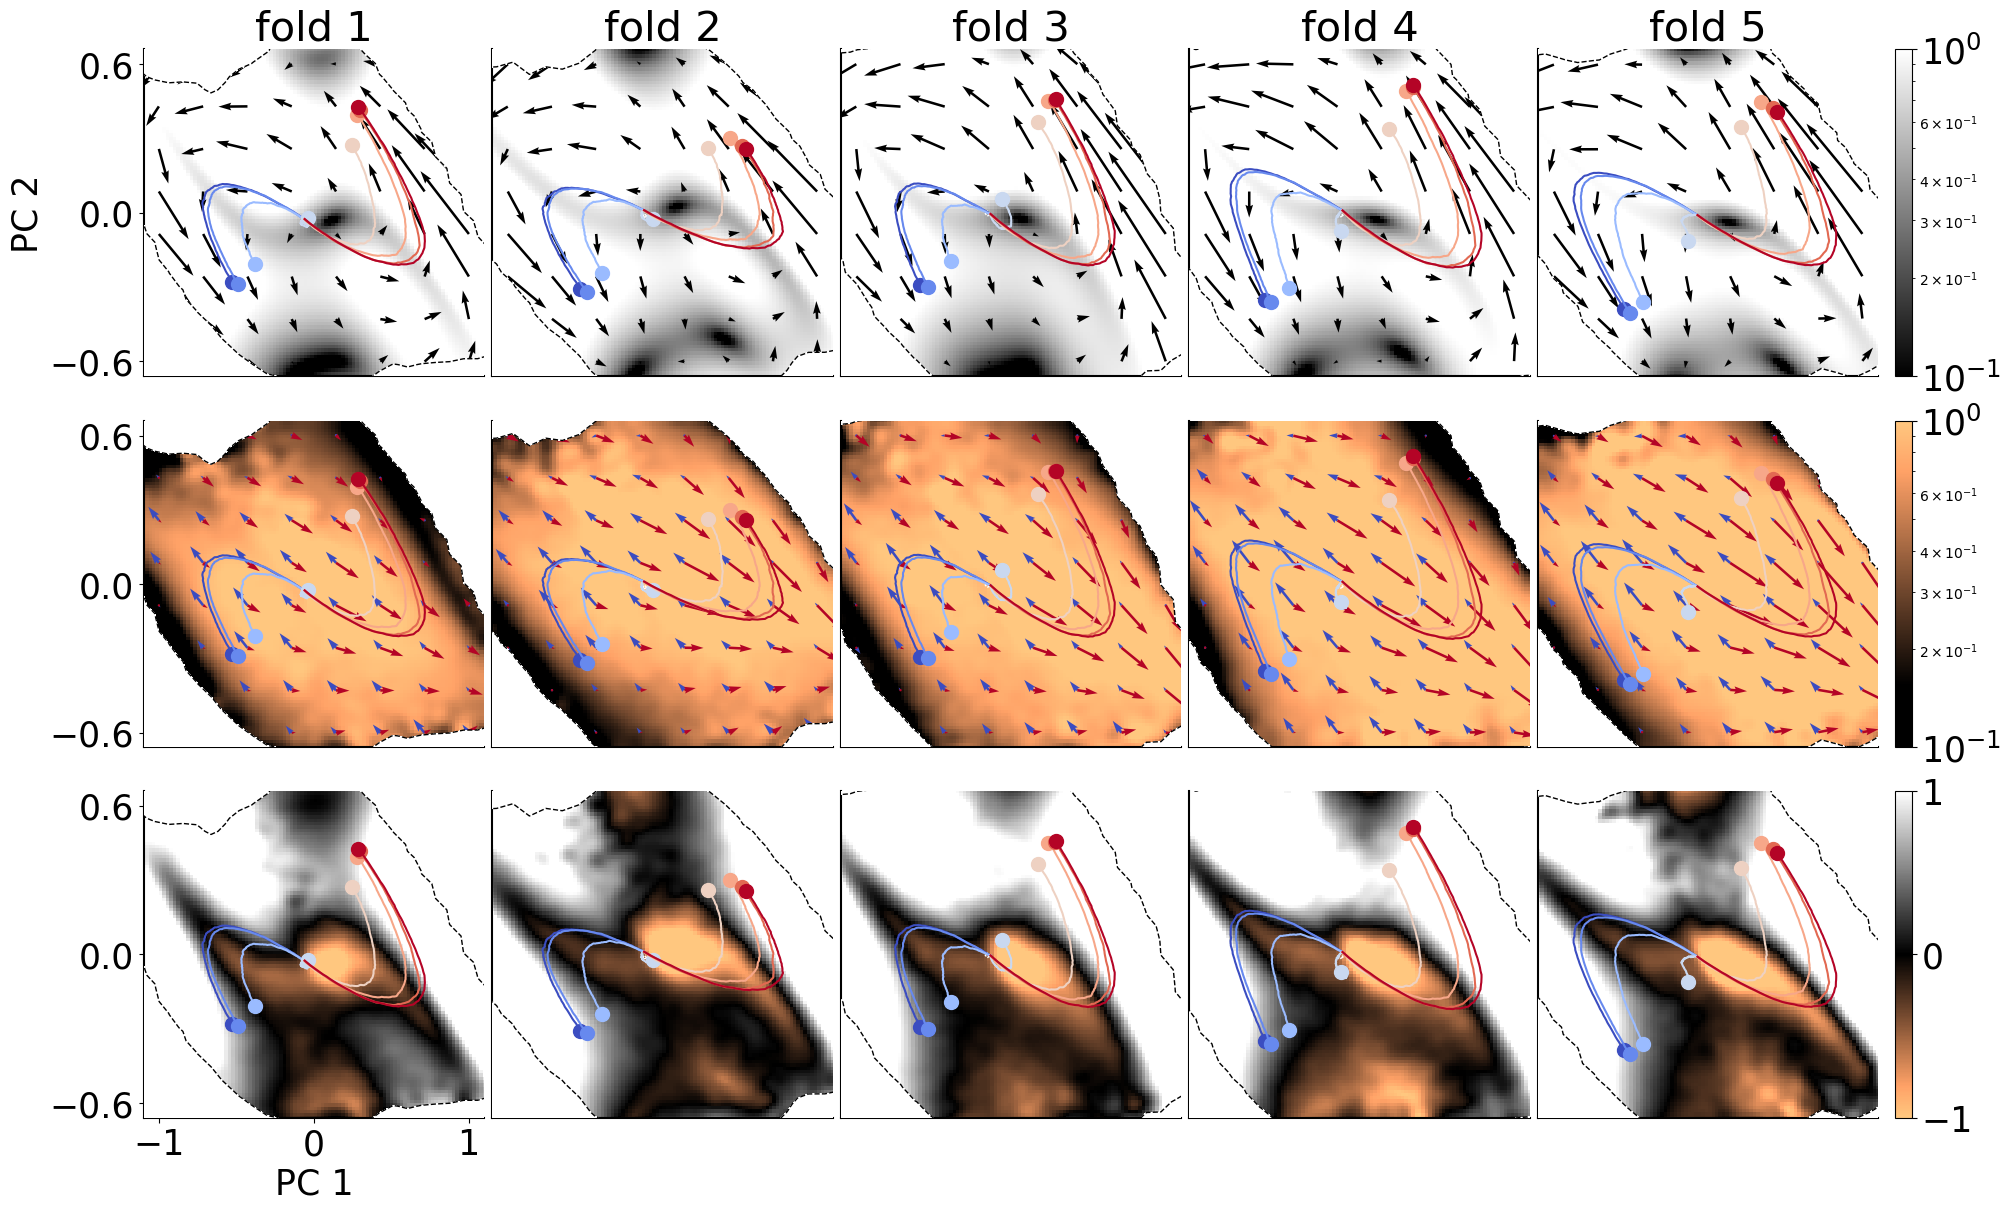

In [5]:
fig, ax = plt.subplots(3, 5, figsize=(20, 12), constrained_layout=True)
norm = colors.Normalize(vmin=-3.5, vmax=3.5)

time=100 # time in 10 ms -- total 1s
evidences = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5] # in gamma

for k in range(5):
    # load vector fields and prior latent trajectories from trained FINDR
    data = np.load(
        '../../data/processed_data/extended_data_figure_4/T176_2018_05_15_fold'+str(k+1)+'.npz'
    )
    x = data['x']
    y = data['y']
    u = data['u']
    v = data['v']
    energy = data['energy']
    x_ = data['x_']
    y_ = data['y_']
    u_ = data['u_']
    v_ = data['v_']
    energy_ = data['energy_']
    u_left = data['u_left']
    v_left = data['v_left']
    energy_left = data['energy_left']
    u_right = data['u_right']
    v_right = data['v_right']
    energy_right = data['energy_right']   
    u_left_ = data['u_left_']
    v_left_ = data['v_left_']
    energy_left_ = data['energy_left_']
    u_right_ = data['u_right_']
    v_right_ = data['v_right_']
    energy_right_ = data['energy_right_']   
    p_lc = data['p_lc']
    p_rc = data['p_rc']
    p_lc_ = data['p_lc_']
    p_rc_ = data['p_rc_']
    z_pc_ = data['z_pc_']
    gammas = np.load("../../data/processed_data/common/gammas.npy")

    xrange = (
        np.abs(np.quantile(z_pc_[:,:,0].flatten(), 0.01)) + \
        np.abs(np.quantile(z_pc_[:,:,0].flatten(), 0.99))
    )/2 # scale the axes so that the latent trajectories lie between -1 and 1 in PC 1 direction
    
    # compute the evidence-conditioned average trajectories
    avg_trajectories = [np.mean(z_pc_[(gammas == evidences[i]),:,:], axis=0) for i in range(len(evidences))]
    
    # perform reflection transformation w.r.t. PC 1 or PC 2 axis
    if max(avg_trajectories[0][:time,0], key=abs) > 0:
        flip_horizontally = -1
    else:
        flip_horizontally = 1
    if max(avg_trajectories[0][:time,1], key=abs) > 0:
        flip_vertically = -1
    else:
        flip_vertically = 1

    # for computing the sample zone
    z_pc__ = np.reshape(z_pc_[:,:time,:], (-1, 2))
    counts,xbins,ybins = np.histogram2d(
        flip_horizontally * z_pc__[:,0] / xrange, 
        flip_vertically * z_pc__[:,1] / xrange,
        bins=30
    )
    xx = flip_horizontally * x/xrange
    yy = flip_vertically * y/xrange
    zz = (xbins[0] < xx) * (xx < xbins[-1]) * (ybins[0] < yy) * (yy < ybins[-1])

    # energy heatmaps
    input_contrib = gaussian_filter((energy_left*p_lc.T + energy_right*p_rc.T)/2, sigma=2)
    recurrent_contrib = energy
    energy_diff = recurrent_contrib - input_contrib

    # plot
    for j in range(3): # autonomous, input-driven, difference
        for i in range(len(evidences)):
            ax[j,k].plot(
                flip_horizontally * avg_trajectories[i][:time, 0]/xrange, 
                flip_vertically * avg_trajectories[i][:time, 1]/xrange, 
                '-', color=cmap(norm(evidences[i])), zorder=1100
            )
            ax[j,k].plot(
                [flip_horizontally * avg_trajectories[i][time, 0]/xrange], 
                [flip_vertically * avg_trajectories[i][time, 1]/xrange], 
                'o', markersize=10, color=cmap(norm(evidences[i])), zorder=1100
            ) # final state at time=1s
        
        ax[j,k].contourf(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
            cmap = cmap1, levels = [-1, 10, 10000], zorder=1000)

        cs = ax[j,k].contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
            linewidths=1, linestyles = "dashed", cmap = 'gray', levels = [10,10000], zorder=1001)

        ax[j,k].contourf(
            flip_horizontally * x/xrange, 
            flip_vertically * y/xrange, 
            zz.astype(int),
            cmap = cmap2, levels = [0, 0.9], zorder=1000
        )

        ax[j,k].spines['top'].set_visible(False)
        ax[j,k].spines['right'].set_visible(False)
        ax[j,k].spines['left'].set_linewidth(1.5)
        ax[j,k].spines['bottom'].set_linewidth(1.5)
        ax[j,k].tick_params(axis='both', which='major', labelsize=25)
        ax[j,k].set_xlim([-1.1, 1.1])
        ax[j,k].set_ylim([-0.66, 0.66])

    ax[0,k].set_title('fold '+str(k+1), fontsize=30)
    c1 = ax[0,k].pcolormesh(
        flip_horizontally * x/xrange, 
        flip_vertically * y/xrange, 
        energy, 
        cmap='gray', 
        norm=colors.LogNorm(vmin=0.1, vmax=1)
    )
    ax[0,k].quiver(
        flip_horizontally * x_/xrange, 
        flip_vertically * y_/xrange, 
        flip_horizontally * u_/xrange, 
        flip_vertically * v_/xrange, 
        angles='xy', color='black', scale_units='xy', scale=10, zorder=150
    )

    c2 = ax[1,k].pcolormesh(
        flip_horizontally * x/xrange, 
        flip_vertically * y/xrange, 
        input_contrib, 
        cmap=mymap2, 
        norm=colors.LogNorm(vmin=0.1, vmax=1)
    )
    ax[1,k].quiver(
        flip_horizontally * x_/xrange, 
        flip_vertically * y_/xrange, 
        flip_horizontally * u_left_/xrange * p_lc_.T, 
        flip_vertically * v_left_/xrange * p_lc_.T, 
        angles='xy', scale_units='xy', scale=10, color=blue, zorder=150
    )
    ax[1,k].quiver(
        flip_horizontally * x_/xrange, 
        flip_vertically * y_/xrange, 
        flip_horizontally * u_right_/xrange * p_rc_.T, 
        flip_vertically * v_right_/xrange * p_rc_.T, 
        angles='xy', scale_units='xy', scale=10, color=red, zorder=150
    )

    c3 = ax[2,k].pcolormesh(
        flip_horizontally * x/xrange, 
        flip_vertically * y/xrange, 
        energy_diff, 
        cmap=mymap,
        norm=colors.Normalize(vmin=-1.0, vmax=1.0)
    )

    ax[0,k].set_xticks([])
    ax[1,k].set_xticks([])
    if k == 0:
        ax[0,k].set_yticks([-0.6, 0, 0.6])
        ax[1,k].set_yticks([-0.6, 0, 0.6])
        ax[2,k].set_yticks([-0.6, 0, 0.6])
        ax[0,k].set_ylabel("PC 2", fontsize=25)
        ax[2,k].set_xticks([-1, 0, 1])
        ax[2,k].set_xlabel("PC 1", fontsize=25)
    else:
        ax[0,k].set_yticks([])
        ax[1,k].set_yticks([])
        ax[2,k].set_yticks([])
        ax[2,k].set_xticks([])
        
# color bars
cbar = fig.colorbar(c1, ax=ax[0,4])
cbar.ax.set_yscale('log')
cbar.ax.set_yticks([0.1, 1])
cbar.ax.tick_params(labelsize=25)

cbar = fig.colorbar(c2, ax=ax[1,4])
cbar.ax.tick_params(labelsize=25)

cbar = fig.colorbar(c3, ax=ax[2,4])
cbar.ax.set_yticks([-1, 0, 1])
cbar.ax.tick_params(labelsize=25)